### Imports

In [81]:
from packages.metagenomics import sampling2, encoding2
from Bio import SeqIO
import numpy as np
from Bio.Seq import Seq
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets
from sklearn.multiclass import OneVsRestClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import shutil
import csv
import datetime
from sklearn.linear_model import LinearRegression
import pandas as pd
from sklearn.metrics import recall_score
import matplotlib.pyplot as plt

### Ideas for model improvement
- consider setting class weights to reflect unequal distribution of data
- try one-vs-all approach
- encode sequences differently depending on whether sequence is a promoter or gene vs CpG islands, etc. Search for known motifs rather than blind k-mer groups.
- use PCA to reduce dimensions first

# Recall score
From the paper: "Performance is measured in terms of species-level recall. We first compute the prediction recall within each species, i.e. the proportion of fragments originating from this species that are correctly classified and consider the average recall observed across species."

In [82]:
y_true = [0, 1, 2, 0, 1, 2]
y_pred = [0, 2, 1, 0, 1, 1]

recall_score(y_true, y_pred, average='weighted')

0.5

# Grid Search 1 - 2000 size dataset (4 samples)

### Run Grid Search 1 - Multiclass Random Forest Classifier

In [83]:
def append_results_to_file(filename, fields=None, rows=None):
    
    with open(filename, 'a') as f:

        write = csv.writer(f)

        if fields:
            write.writerow(fields)

        if rows:
            write.writerows(rows)

In [84]:
def run_rf_classification(X_train, X_test, y_train,y_test, max_depth, n_estimators, seed):
    """
    Score is subset accuracy.
    """
   
    rf = RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimators, random_state=seed)
    rf.fit(X_train,y_train)
    score = rf.score(X_test, y_test)
    return score
    

In [85]:
def run_rf_classification_recall(X_train, X_test, y_train,y_test, max_depth, n_estimators, seed):
    """
    Score is species level recall.
    """
   
    rf = RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimators, random_state=seed)
    rf.fit(X_train,y_train)
    y_pred = rf.predict(X_test)
    score = recall_score(y_test, y_pred, average='weighted')
    return score
    

In [86]:
def build_fragments(seq_file, taxid_file, output_dir, sample_length, coverage, seed):
    # delete output directory if it previously exists
    try:
        shutil.rmtree(output_dir)
    except FileNotFoundError:
        print('Existing directory was not found. Process will generate a directory.')

    # build fragments
    sampling2.generate_fragment_data(seq_file, taxid_file, output_dir, sample_length, coverage, seed)

In [87]:
def encode_fragments(output_dir, pattern, k, seed):
    
    # encode data
    fragments = sampling2.read_fragments(output_dir, pattern)
    X_enc, y = encoding2.encode_fragment_dataset(fragments,k)
    le = preprocessing.LabelEncoder()
    y_enc = le.fit_transform(y)

    # split data into test and training
    X_train, X_test, y_train, y_test = train_test_split(X_enc, y_enc, test_size=0.33, random_state=seed)
    
    print(X_enc.shape)
    
    return X_train, X_test, y_train, y_test

In [88]:
def calc_number_combinations(list_sample_length,list_coverage,list_k,list_max_depth,list_n_estimators):
    n = len(list_sample_length) * len(list_coverage) * len(list_k) *len(list_max_depth) * len(list_n_estimators)
    return n

In [89]:
def grid_search_multiclass_rf(seq_file, 
                              taxid_file, 
                              output_dir, 
                              pattern, 
                              list_sample_length, 
                              list_coverage, 
                              list_k,
                              list_max_depth, 
                              list_n_estimators, 
                              seed,
                              grid_search_file,
                              fields,
                              experiment,
                             score_type):
    
    # set up grid search results file
    append_results_to_file(grid_search_file, fields)
    
    # calculate number of combinations
    n_combinations = calc_number_combinations(list_sample_length,list_coverage,list_k,list_max_depth,list_n_estimators)
    
    # process combinations
    count = 0
    for sample_length in list_sample_length:
        for coverage in list_coverage:
            
            # fragment combination
            build_fragments(seq_file, taxid_file, output_dir, sample_length, coverage, seed)
            for k in list_k:
                
                # kmer combination
                X_train, X_test, y_train, y_test = encode_fragments(output_dir, pattern,k,seed)
                for max_depth in list_max_depth:
                    for n_estimators in list_n_estimators:
                        
                        # random forest combination
                        score = run_rf_classification_recall(X_train, X_test, y_train,y_test, max_depth, n_estimators, seed)
                        count += 1
                        
                        # output results to file
                        row = [experiment, 'multiclass', 'Random Forest', X_train.shape, sample_length, coverage, k, max_depth, n_estimators, score, score_type]
                        append_results_to_file(grid_search_file, row)
                        
                print('Percent complete: {}'.format(count / n_combinations * 100)) # display progress
    

In [90]:
def calc_hyperparameter_relationship(filename):
    """
    Runs logistic regression over hyperparameters to find the regression coefficients.
    This should give some indicator of how hyperparameters are affecting the score.
    """
    # read in grid search results
    df = pd.read_csv(filename)
    X = df.drop(['experiment','score', 'category','classifier'],axis=1)
    y = df['score']
    
    lr = LinearRegression()
    lr.fit(X,y)
    return lr.coef_

In [125]:
def get_line(sample_length, coverage, df):
    data = df[(df['sample_length'] == sample_length) & (df['coverage']==coverage)].drop(['sample_length', 'coverage'],axis=1)
    return data['k'].tolist(), data['score'].tolist()


In [126]:
def plot_graphs(filename):
    
    df = pd.read_csv(filename)
    df = df.drop(['experiment','category','classifier','training shape', 'score type', 'max_depth','n_estimators'],axis=1)
   
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
#     fig.tight_layout()

    # graph 1
    L=100
    line_L100_C0_1_k, line_L100_C0_1_score = get_line(L, 0.1, df)
    line_L100_C1_k, line_L100_C1_score = get_line(L, 1, df)
    line_L100_C10_k, line_L100_C10_score = get_line(L, 10, df)
    line_L100_C100_k, line_L100_C100_score = get_line(L, 100, df)
    line_L100_C200_k, line_L100_C200_score = get_line(L, 200, df)
    line_L100_C400_k, line_L100_C400_score = get_line(L, 400, df)
    
    ax1.plot(line_L100_C0_1_k, line_L100_C0_1_score, linestyle=':', label='cov=0.1',color='k')
    ax1.plot(line_L100_C1_k, line_L100_C1_score, linestyle='--', label='cov=1',color='k')
    ax1.plot(line_L100_C10_k, line_L100_C10_score, linestyle='-', label='cov=10',color='gray')
    ax1.plot(line_L100_C100_k, line_L100_C100_score, linestyle='--', label='cov=100',color='gray')
    ax1.plot(line_L100_C200_k, line_L100_C200_score, linestyle='-.', label='cov=200',color='k')
    ax1.plot(line_L100_C400_k, line_L100_C400_score, linestyle='-', label='cov=400',color='k')

    ax1.set_xticks([0, 1, 2,4,6,8,10,12])
    ax1.legend()
    ax1.set_title('L=100')
    ax1.set_ylabel('average species-level recall')
    ax1.set_xlabel('k-mer size')
    ax1.grid(color='lightgray', linestyle=':', linewidth=1)
    
    # graph 2
    L=200
    line_L200_C0_1_k, line_L200_C0_1_score = get_line(L, 0.1, df)
    line_L200_C1_k, line_L200_C1_score = get_line(L, 1, df)
    line_L200_C10_k, line_L200_C10_score = get_line(L, 10, df)
    line_L200_C100_k, line_L200_C100_score = get_line(L, 100, df)
    line_L200_C200_k, line_L200_C200_score = get_line(L, 200, df)
    line_L200_C400_k, line_L200_C400_score = get_line(L, 400, df)
    
    
    ax2.plot(line_L200_C0_1_k, line_L200_C0_1_score, linestyle=':', label='cov=0.1',color='k')
    ax2.plot(line_L200_C1_k, line_L200_C1_score, linestyle='--', label='cov=1',color='k')
    ax2.plot(line_L200_C10_k, line_L200_C10_score, linestyle='-', label='cov=10',color='gray')
    ax2.plot(line_L200_C100_k, line_L200_C100_score, linestyle='--', label='cov=100',color='gray')
    ax2.plot(line_L200_C200_k, line_L200_C200_score, linestyle='-.', label='cov=200',color='k')
    ax2.plot(line_L200_C400_k, line_L200_C400_score, linestyle='-', label='cov=400',color='k')

    ax2.set_xticks([0, 1, 2,4,6,8,10,12])
    ax2.legend()
    ax2.set_title('L=200')
    ax2.set_ylabel('average species-level recall')
    ax2.set_xlabel('k-mer size')
    ax2.grid(color='lightgray', linestyle=':', linewidth=1)
    
    # graph 3
    L=400
    line_L400_C0_1_k, line_L400_C0_1_score = get_line(L, 0.1, df)
    line_L400_C1_k, line_L400_C1_score = get_line(L, 1, df)
    line_L400_C10_k, line_L400_C10_score = get_line(L, 10, df)
    line_L400_C100_k, line_L400_C100_score = get_line(L, 100, df)
    line_L400_C200_k, line_L400_C200_score = get_line(L, 200, df)
    line_L400_C400_k, line_L400_C400_score = get_line(L, 400, df)

    
    ax3.plot(line_L400_C0_1_k, line_L400_C0_1_score, linestyle=':', label='cov=0.1',color='k')
    ax3.plot(line_L400_C1_k, line_L400_C1_score, linestyle='--', label='cov=1',color='k')
    ax3.plot(line_L400_C10_k, line_L400_C10_score, linestyle='-', label='cov=10',color='gray')
    ax3.plot(line_L400_C100_k, line_L400_C100_score, linestyle='--', label='cov=100',color='gray')
    ax3.plot(line_L400_C200_k, line_L400_C200_score, linestyle='-.', label='cov=200',color='k')
    ax3.plot(line_L400_C400_k, line_L400_C400_score, linestyle='-', label='cov=400',color='k')

    ax3.set_xticks([0, 1, 2,4,6,8,10,12])
    ax3.legend()
    ax3.set_title('L=400')
    ax3.set_ylabel('average species-level recall')
    ax3.set_xlabel('k-mer size')
    ax3.grid(color='lightgray', linestyle=':', linewidth=1)
    
    plt.suptitle("Random Forest Classifier (max_depth=15, n_estimators=50)", fontsize=16)
    plt.show()
    

### Search 1.1

In [92]:
# %%time

# # parameters
# seq_file = 'data/train_small-db_toy-2000.fasta'
# taxid_file = 'data/train_small-db_toy-2000.taxid'
# output_dir = 'data/sampling/sampling-toy-2000'
# pattern = 'fragments*.npy'
# seed = 42
# grid_search_file  = 'data/gridsearch/rf-multi.' + datetime.datetime.now().strftime('%Y.%m.%d.%H.%M.%S') + '.csv'
# fields = ['category','classifier','sample_length','coverage','k','max_depth', 'n_estimators', 'score']

# # combinations to try
# list_sample_length = [100, 200, 400]
# list_coverage = [0.1, 1, 2, 10]
# list_k = [i for i in range(1,10,2)]
# list_max_depth = [i for i in range(2,20,4)]
# list_n_estimators = [i for i in range(20,200,40)]


# grid_search_multiclass_rf(seq_file, 
#                           taxid_file, 
#                           output_dir, 
#                           pattern, 
#                           list_sample_length, 
#                           list_coverage, 
#                           list_k, 
#                           list_max_depth,
#                           list_n_estimators, 
#                           seed,
#                           grid_search_file,
#                           fields )




In [93]:
# gridsearch_file = 'data/gridsearch/rf-multi.2021.03.28.18.07.15.csv'
# calc_hyperparameter_relationship(gridsearch_file)
# # array([-1.44909382e-04,  1.67645287e-02, -9.17412031e-03,  1.18482770e-03, -1.44167915e-05])

### Search 1.2

In [94]:
# %%time
# 3h 37min 3s

# # parameters
# seq_file = 'data/train_small-db_toy-2000.fasta'
# taxid_file = 'data/train_small-db_toy-2000.taxid'
# output_dir = 'data/sampling/sampling-toy-2000'
# pattern = 'fragments*.npy'
# seed = 42
# grid_search_file  = 'data/gridsearch/rf-multi.' + datetime.datetime.now().strftime('%Y.%m.%d.%H.%M.%S') + '.csv'
# fields = ['category','classifier','sample_length','coverage','k','max_depth', 'n_estimators', 'score']

# # combinations to try
# list_sample_length = [200, 400]
# list_coverage = [1,10,100,200]
# list_k = [i for i in range(1,20,2)]
# list_max_depth = [i for i in range(6,20,2)]
# list_n_estimators = [i for i in range(50,501,50)]


# grid_search_multiclass_rf(seq_file, 
#                           taxid_file, 
#                           output_dir, 
#                           pattern, 
#                           list_sample_length, 
#                           list_coverage, 
#                           list_k, 
#                           list_max_depth,
#                           list_n_estimators, 
#                           seed,
#                           grid_search_file,
#                           fields )




In [95]:
# gridsearch_file = 'data/gridsearch/rf-multi.2021.03.28.18.31.24.csv'
# calc_hyperparameter_relationship(gridsearch_file)
# # array([-1.79147764e-04,  8.02651943e-04, -1.15739138e-02,  2.46285125e-03, 4.98644276e-06])

### Search 1.3

In [96]:
# %%time
## 2h

# # parameters
# seq_file = 'data/train_small-db_toy-2000.fasta'
# taxid_file = 'data/train_small-db_toy-2000.taxid'
# output_dir = 'data/sampling/sampling-toy-2000'
# pattern = 'fragments*.npy'
# seed = 42
# grid_search_file  = 'data/gridsearch/rf-multi.{}.csv'.format(datetime.datetime.now().strftime('%Y.%m.%d.%H.%M.%S') )
# fields = ['experiment','category','classifier','sample_length','coverage','k','max_depth', 'n_estimators', 'score']
# experiment = '1.3'

# # combinations to try
# list_sample_length = [100, 200, 400]
# list_coverage = [0.1,1,10,100,200]
# list_k = [1,2,4,8]
# list_max_depth = [i for i in range(20,51,10)]
# list_n_estimators = [50,100,200,400,800]


# grid_search_multiclass_rf(seq_file, 
#                           taxid_file, 
#                           output_dir, 
#                           pattern, 
#                           list_sample_length, 
#                           list_coverage, 
#                           list_k, 
#                           list_max_depth,
#                           list_n_estimators, 
#                           seed,
#                           grid_search_file,
#                           fields,
#                           experiment)


### Search 1.4
Stopped short after realizing I didn't need to try as small intervals of max depth

In [97]:
# %%time

# # parameters
# seq_file = 'data/train_small-db_toy-2000.fasta'
# taxid_file = 'data/train_small-db_toy-2000.taxid'
# output_dir = 'data/sampling/sampling-toy-2000'
# pattern = 'fragments*.npy'
# seed = 42
# grid_search_file  = 'data/gridsearch/rf-multi.{}.csv'.format(datetime.datetime.now().strftime('%Y.%m.%d.%H.%M.%S') )
# fields = ['experiment','category','classifier','sample_length','coverage','k','max_depth', 'n_estimators', 'score']
# experiment = '1.4'

# # combinations to try
# list_sample_length = [100]
# list_coverage = [200]
# list_k = [1]
# list_max_depth = [50]
# list_n_estimators = [50,100,200,400,800,1600,3200]


# grid_search_multiclass_rf(seq_file, 
#                           taxid_file, 
#                           output_dir, 
#                           pattern, 
#                           list_sample_length, 
#                           list_coverage, 
#                           list_k, 
#                           list_max_depth,
#                           list_n_estimators, 
#                           seed,
#                           grid_search_file,
#                           fields,
#                           experiment)


### Search 1.5

In [98]:
# %%time
## 5.5 h

# # parameters
# seq_file = 'data/train_small-db_toy-2000.fasta'
# taxid_file = 'data/train_small-db_toy-2000.taxid'
# output_dir = 'data/sampling/sampling-toy-2000'
# pattern = 'fragments*.npy'
# seed = 42
# grid_search_file  = 'data/gridsearch/rf-multi.{}.csv'.format(datetime.datetime.now().strftime('%Y.%m.%d.%H.%M.%S') )
# fields = ['experiment','category','classifier','sample_length','coverage','k','max_depth', 'n_estimators', 'score']
# experiment = '1.5'

# # combinations to try
# list_sample_length = [100, 200, 400]
# list_coverage = [200]
# list_k = [1,2,4,6]
# list_max_depth = [50, 100, 200]
# list_n_estimators = [50,100,200,400,800,1600,3200]


# grid_search_multiclass_rf(seq_file, 
#                           taxid_file, 
#                           output_dir, 
#                           pattern, 
#                           list_sample_length, 
#                           list_coverage, 
#                           list_k, 
#                           list_max_depth,
#                           list_n_estimators, 
#                           seed,
#                           grid_search_file,
#                           fields,
#                           experiment)


### Search 1.6

In [99]:
# %%time
# #2.25 h

# # parameters
# seq_file = 'data/train_small-db_toy-2000.fasta'
# taxid_file = 'data/train_small-db_toy-2000.taxid'
# output_dir = 'data/sampling/sampling-toy-2000'
# pattern = 'fragments*.npy'
# seed = 42
# grid_search_file  = 'data/gridsearch/rf-multi.{}.csv'.format(datetime.datetime.now().strftime('%Y.%m.%d.%H.%M.%S') )
# fields = ['experiment','category','classifier','sample_length','coverage','k','max_depth', 'n_estimators', 'score']
# experiment = '1.6'

# # combinations to try
# list_sample_length = [100]
# list_coverage = [200]
# list_k = [1,2,3]
# list_max_depth = [55, 65, 75, 85, 95]
# list_n_estimators = [400,500,600,700,800]


# grid_search_multiclass_rf(seq_file, 
#                           taxid_file, 
#                           output_dir, 
#                           pattern, 
#                           list_sample_length, 
#                           list_coverage, 
#                           list_k, 
#                           list_max_depth,
#                           list_n_estimators, 
#                           seed,
#                           grid_search_file,
#                           fields,
#                           experiment)


In [100]:
# gridsearch_file = 'data/gridsearch/rf-multi-all.csv'
# calc_hyperparameter_relationship(gridsearch_file)
# # array([-1.95530967e-04,  1.27461350e-03, -1.10693995e-02,  1.45827089e-03, 4.77729253e-05])
# # x1000 =
# # -0.19  sample length
# #  1.27  coverage
# # -10    k
# #  1.45  max_depth
# #  0.047 n_estimators

### Search 1.7

In [101]:
# %%time
# #12 min

# # parameters
# seq_file = 'data/train_small-db_toy-2000.fasta'
# taxid_file = 'data/train_small-db_toy-2000.taxid'
# output_dir = 'data/sampling/sampling-toy-2000'
# pattern = 'fragments*.npy'
# seed = 42
# grid_search_file  = 'data/gridsearch/rf-multi.{}.csv'.format(datetime.datetime.now().strftime('%Y.%m.%d.%H.%M.%S') )
# fields = ['experiment','category','classifier','sample_length','coverage','k','max_depth', 'n_estimators', 'score']
# experiment = '1.7'

# # combinations to try
# list_sample_length = [100]
# list_coverage = [200]
# list_k = [2]
# list_max_depth = [i for i in range(1,501, 50)]
# list_n_estimators = [500]


# grid_search_multiclass_rf(seq_file, 
#                           taxid_file, 
#                           output_dir, 
#                           pattern, 
#                           list_sample_length, 
#                           list_coverage, 
#                           list_k, 
#                           list_max_depth,
#                           list_n_estimators, 
#                           seed,
#                           grid_search_file,
#                           fields,
#                           experiment)


### Search 1.8

In [102]:
# %%time
# # 9 min

# # parameters
# seq_file = 'data/train_small-db_toy-2000.fasta'
# taxid_file = 'data/train_small-db_toy-2000.taxid'
# output_dir = 'data/sampling/sampling-toy-2000'
# pattern = 'fragments*.npy'
# seed = 42
# grid_search_file  = 'data/gridsearch/rf-multi.{}.csv'.format(datetime.datetime.now().strftime('%Y.%m.%d.%H.%M.%S') )
# fields = ['experiment','category','classifier','sample_length','coverage','k','max_depth', 'n_estimators', 'score']
# experiment = '1.8'

# # combinations to try
# list_sample_length = [100]
# list_coverage = [200]
# list_k = [2]
# list_max_depth = [i for i in range(1,101, 10)]
# list_n_estimators = [500]


# grid_search_multiclass_rf(seq_file, 
#                           taxid_file, 
#                           output_dir, 
#                           pattern, 
#                           list_sample_length, 
#                           list_coverage, 
#                           list_k, 
#                           list_max_depth,
#                           list_n_estimators, 
#                           seed,
#                           grid_search_file,
#                           fields,
#                           experiment)


### Search 1.9

In [103]:
# %%time
# # 51 min

# # parameters
# seq_file = 'data/train_small-db_toy-2000.fasta'
# taxid_file = 'data/train_small-db_toy-2000.taxid'
# output_dir = 'data/sampling/sampling-toy-2000'
# pattern = 'fragments*.npy'
# seed = 42
# grid_search_file  = 'data/gridsearch/rf-multi.{}.csv'.format(datetime.datetime.now().strftime('%Y.%m.%d.%H.%M.%S') )
# fields = ['experiment','category','classifier','sample_length','coverage','k','max_depth', 'n_estimators', 'score']
# experiment = '1.9'

# # combinations to try
# list_sample_length = [100]
# list_coverage = [200]
# list_k = [2]
# list_max_depth = [i for i in range(10,101, 2)]
# list_n_estimators = [500]


# grid_search_multiclass_rf(seq_file, 
#                           taxid_file, 
#                           output_dir, 
#                           pattern, 
#                           list_sample_length, 
#                           list_coverage, 
#                           list_k, 
#                           list_max_depth,
#                           list_n_estimators, 
#                           seed,
#                           grid_search_file,
#                           fields,
#                           experiment)


### Search 1.10

In [104]:
# %%time
# # 16 min

# # parameters
# seq_file = 'data/train_small-db_toy-2000.fasta'
# taxid_file = 'data/train_small-db_toy-2000.taxid'
# output_dir = 'data/sampling/sampling-toy-2000'
# pattern = 'fragments*.npy'
# seed = 42
# grid_search_file  = 'data/gridsearch/rf-multi.{}.csv'.format(datetime.datetime.now().strftime('%Y.%m.%d.%H.%M.%S') )
# fields = ['experiment','category','classifier','sample_length','coverage','k','max_depth', 'n_estimators', 'score']
# experiment = '1.10'

# # combinations to try
# list_sample_length = [100]
# list_coverage = [200]
# list_k = [2]
# list_max_depth = [72]
# list_n_estimators = [i for i in range(2,103,10)] + [i for i in range(100,1001,100)]


# grid_search_multiclass_rf(seq_file, 
#                           taxid_file, 
#                           output_dir, 
#                           pattern, 
#                           list_sample_length, 
#                           list_coverage, 
#                           list_k, 
#                           list_max_depth,
#                           list_n_estimators, 
#                           seed,
#                           grid_search_file,
#                           fields,
#                           experiment)


### Search 1.11

In [105]:
# %%time
# # 12 min

# # parameters
# seq_file = 'data/train_small-db_toy-2000.fasta'
# taxid_file = 'data/train_small-db_toy-2000.taxid'
# output_dir = 'data/sampling/sampling-toy-2000'
# pattern = 'fragments*.npy'
# seed = 42
# grid_search_file  = 'data/gridsearch/rf-multi.{}.csv'.format(datetime.datetime.now().strftime('%Y.%m.%d.%H.%M.%S') )
# fields = ['experiment','category','classifier','sample_length','coverage','k','max_depth', 'n_estimators', 'score']
# experiment = '1.11'

# # combinations to try
# list_sample_length = [100]
# list_coverage = [200]
# list_k = [2]
# list_max_depth = [72]
# list_n_estimators = [i for i in range(200,501,25)]


# grid_search_multiclass_rf(seq_file, 
#                           taxid_file, 
#                           output_dir, 
#                           pattern, 
#                           list_sample_length, 
#                           list_coverage, 
#                           list_k, 
#                           list_max_depth,
#                           list_n_estimators, 
#                           seed,
#                           grid_search_file,
#                           fields,
#                           experiment)


### Search 1.12

In [106]:
# %%time
# # 1h


# # parameters
# seq_file = 'data/train_small-db_toy-2000.fasta'
# taxid_file = 'data/train_small-db_toy-2000.taxid'
# output_dir = 'data/sampling/sampling-toy-2000'
# pattern = 'fragments*.npy'
# seed = 42
# grid_search_file  = 'data/gridsearch/rf-multi.{}.csv'.format(datetime.datetime.now().strftime('%Y.%m.%d.%H.%M.%S') )
# fields = ['experiment','category','classifier','sample_length','coverage','k','max_depth', 'n_estimators', 'score']
# experiment = '1.12'

# # combinations to try
# list_sample_length = [100,200,400]
# list_coverage = [10,20,50,100,200,400]
# list_k = [1,2,4,6,8,10,12,14,16,18,20]
# list_max_depth = [72]
# list_n_estimators = [500]


# grid_search_multiclass_rf(seq_file, 
#                           taxid_file, 
#                           output_dir, 
#                           pattern, 
#                           list_sample_length, 
#                           list_coverage, 
#                           list_k, 
#                           list_max_depth,
#                           list_n_estimators, 
#                           seed,
#                           grid_search_file,
#                           fields,
#                           experiment)


### Search 1.13
Searching over smaller max_depth and n_estimator space due to limitations as we scale up.

In [107]:
# %%time
# # 22 min


# # parameters
# seq_file = 'data/train_small-db_toy-2000.fasta'
# taxid_file = 'data/train_small-db_toy-2000.taxid'
# output_dir = 'data/sampling/sampling-toy-2000'
# pattern = 'fragments*.npy'
# seed = 42
# grid_search_file  = 'data/gridsearch-2000/rf-multi.{}.csv'.format(datetime.datetime.now().strftime('%Y.%m.%d.%H.%M.%S') )
# fields = ['experiment','category','classifier','training shape','sample_length','coverage','k','max_depth', 'n_estimators', 'score']
# experiment = '1.13'

# # combinations to try
# list_sample_length = [100,200,400]
# list_coverage = [10,100,200,400]
# list_k = [1,2,4]
# list_max_depth = [i for i in range(5,30,5)]
# list_n_estimators = [i for i in range(20,50,5)]


# grid_search_multiclass_rf(seq_file, 
#                           taxid_file, 
#                           output_dir, 
#                           pattern, 
#                           list_sample_length, 
#                           list_coverage, 
#                           list_k, 
#                           list_max_depth,
#                           list_n_estimators, 
#                           seed,
#                           grid_search_file,
#                           fields,
#                           experiment)


### Search 1.14
Switching to species-level recall and rechecking highest values.

In [108]:
# %%time


# # parameters
# seq_file = 'data/train_small-db_toy-2000.fasta'
# taxid_file = 'data/train_small-db_toy-2000.taxid'
# output_dir = 'data/sampling/sampling-toy-2000'
# pattern = 'fragments*.npy'
# seed = 42
# grid_search_file  = 'data/gridsearch-2000/rf-multi.{}.csv'.format(datetime.datetime.now().strftime('%Y.%m.%d.%H.%M.%S') )
# fields = ['experiment','category','classifier','training shape','sample_length','coverage','k','max_depth', 'n_estimators', 'score','score type']
# experiment = '1.14'
# score_type = 'species_recall'

# # combinations to try
# list_sample_length = [100]
# list_coverage = [400]
# list_k = [1]
# list_max_depth = [15]
# list_n_estimators = [45]


# grid_search_multiclass_rf(seq_file, 
#                           taxid_file, 
#                           output_dir, 
#                           pattern, 
#                           list_sample_length, 
#                           list_coverage, 
#                           list_k, 
#                           list_max_depth,
#                           list_n_estimators, 
#                           seed,
#                           grid_search_file,
#                           fields,
#                           experiment,
#                           score_type)


# Grid Search 2 - 10000 size dataset (198 examples)

### Search 2.01
Determine if method even works with new data.
Result: takes a long time to complete even a single run with 500 estimators and 72 max depth. May need to reduce one or both - reconsider how grid search 1 performs with higher coverage but lower estimators / depth.

In [109]:
# %%time
# # 47 min


# # parameters
# seq_file = 'data/train_small-db_toy-10000.fasta'
# taxid_file = 'data/train_small-db_toy-10000.taxid'
# output_dir = 'data/sampling/sampling-toy-10000'
# pattern = 'fragments*.npy'
# seed = 42
# date_time = datetime.datetime.now().strftime('%Y.%m.%d.%H.%M.%S')
# grid_search_file  = 'data/gridsearch-10000/rf-multi.{}.csv'.format(date_time )
# fields = ['experiment','category','classifier','training shape','sample_length','coverage','k','max_depth', 'n_estimators', 'score']
# experiment = '2.01'

# # combinations to try
# list_sample_length = [100]
# list_coverage = [10]
# list_k = [1]
# list_max_depth = [72]
# list_n_estimators = [500]


# grid_search_multiclass_rf(seq_file, 
#                           taxid_file, 
#                           output_dir, 
#                           pattern, 
#                           list_sample_length, 
#                           list_coverage, 
#                           list_k, 
#                           list_max_depth,
#                           list_n_estimators, 
#                           seed,
#                           grid_search_file,
#                           fields,
#                           experiment)


### Search 2.02
10x less estimators. Checking to see how time changes.

In [110]:
# %%time
# # 5 min


# # parameters
# seq_file = 'data/train_small-db_toy-10000.fasta'
# taxid_file = 'data/train_small-db_toy-10000.taxid'
# output_dir = 'data/sampling/sampling-toy-10000'
# pattern = 'fragments*.npy'
# seed = 42
# date_time = datetime.datetime.now().strftime('%Y.%m.%d.%H.%M.%S')
# grid_search_file  = 'data/gridsearch-10000/rf-multi.{}.csv'.format(date_time )
# fields = ['experiment','category','classifier','training shape','sample_length','coverage','k','max_depth', 'n_estimators', 'score']
# experiment = '2.02'

# # combinations to try
# list_sample_length = [100]
# list_coverage = [10]
# list_k = [1]
# list_max_depth = [72]
# list_n_estimators = [50]


# grid_search_multiclass_rf(seq_file, 
#                           taxid_file, 
#                           output_dir, 
#                           pattern, 
#                           list_sample_length, 
#                           list_coverage, 
#                           list_k, 
#                           list_max_depth,
#                           list_n_estimators, 
#                           seed,
#                           grid_search_file,
#                           fields,
#                           experiment)


### Search 2.03
10x less depth. Checking to see how time changes.

In [111]:
# %%time
# # 2 min

# # parameters
# seq_file = 'data/train_small-db_toy-10000.fasta'
# taxid_file = 'data/train_small-db_toy-10000.taxid'
# output_dir = 'data/sampling/sampling-toy-10000'
# pattern = 'fragments*.npy'
# seed = 42
# date_time = datetime.datetime.now().strftime('%Y.%m.%d.%H.%M.%S')
# grid_search_file  = 'data/gridsearch-10000/rf-multi.{}.csv'.format(date_time )
# fields = ['experiment','category','classifier','training shape','sample_length','coverage','k','max_depth', 'n_estimators', 'score']
# experiment = '2.03'

# # combinations to try
# list_sample_length = [100]
# list_coverage = [10]
# list_k = [1]
# list_max_depth = [7]
# list_n_estimators = [500]


# grid_search_multiclass_rf(seq_file, 
#                           taxid_file, 
#                           output_dir, 
#                           pattern, 
#                           list_sample_length, 
#                           list_coverage, 
#                           list_k, 
#                           list_max_depth,
#                           list_n_estimators, 
#                           seed,
#                           grid_search_file,
#                           fields,
#                           experiment)


### Search 2.04
Stopped early because we don't need to try k values higher than 4 because the accuracy is very low.

In [112]:
# %%time


# # parameters
# seq_file = 'data/train_small-db_toy-10000.fasta'
# taxid_file = 'data/train_small-db_toy-10000.taxid'
# output_dir = 'data/sampling/sampling-toy-10000'
# pattern = 'fragments*.npy'
# seed = 42
# date_time = datetime.datetime.now().strftime('%Y.%m.%d.%H.%M.%S')
# grid_search_file  = 'data/gridsearch-10000/rf-multi.{}.csv'.format(date_time )
# fields = ['experiment','category','classifier','training shape','sample_length','coverage','k','max_depth', 'n_estimators', 'score']
# experiment = '2.04'

# # combinations to try
# list_sample_length = [100,200,400]
# list_coverage = [20,50,100,200,400]
# list_k = [1,2,4,6,8,10,12]
# list_max_depth = [72]
# list_n_estimators = [50]


# grid_search_multiclass_rf(seq_file, 
#                           taxid_file, 
#                           output_dir, 
#                           pattern, 
#                           list_sample_length, 
#                           list_coverage, 
#                           list_k, 
#                           list_max_depth,
#                           list_n_estimators, 
#                           seed,
#                           grid_search_file,
#                           fields,
#                           experiment)


### Search 2.05
Stopped after first run at 400x sample coverage. Took at least 10 hours for that run alone, maybe longer.

In [113]:
# %%time


# # parameters
# seq_file = 'data/train_small-db_toy-10000.fasta'
# taxid_file = 'data/train_small-db_toy-10000.taxid'
# output_dir = 'data/sampling/sampling-toy-10000'
# pattern = 'fragments*.npy'
# seed = 42
# date_time = datetime.datetime.now().strftime('%Y.%m.%d.%H.%M.%S')
# grid_search_file  = 'data/gridsearch-10000/rf-multi.{}.csv'.format(date_time )
# fields = ['experiment','category','classifier','training shape','sample_length','coverage','k','max_depth', 'n_estimators', 'score']
# experiment = '2.05'

# # combinations to try
# list_sample_length = [200,400]
# list_coverage = [10,50,100,200,400]
# list_k = [1,2,4]
# list_max_depth = [72]
# list_n_estimators = [50]


# grid_search_multiclass_rf(seq_file, 
#                           taxid_file, 
#                           output_dir, 
#                           pattern, 
#                           list_sample_length, 
#                           list_coverage, 
#                           list_k, 
#                           list_max_depth,
#                           list_n_estimators, 
#                           seed,
#                           grid_search_file,
#                           fields,
#                           experiment)


### Search 2.06
Testing with small max_depth.

In [114]:
# %%time
# # 10 h 15 min

# # parameters
# seq_file = 'data/train_small-db_toy-10000.fasta'
# taxid_file = 'data/train_small-db_toy-10000.taxid'
# output_dir = 'data/sampling/sampling-toy-10000'
# pattern = 'fragments*.npy'
# seed = 42
# date_time = datetime.datetime.now().strftime('%Y.%m.%d.%H.%M.%S')
# grid_search_file  = 'data/gridsearch-10000/rf-multi.{}.csv'.format(date_time )
# fields = ['experiment','category','classifier','training shape','sample_length','coverage','k','max_depth', 'n_estimators', 'score']
# experiment = '2.06'

# # combinations to try
# list_sample_length = [100,200,400]
# list_coverage = [10,100,200,400]
# list_k = [1,2,4]
# list_max_depth = [15]
# list_n_estimators = [45]


# grid_search_multiclass_rf(seq_file, 
#                           taxid_file, 
#                           output_dir, 
#                           pattern, 
#                           list_sample_length, 
#                           list_coverage, 
#                           list_k, 
#                           list_max_depth,
#                           list_n_estimators, 
#                           seed,
#                           grid_search_file,
#                           fields,
#                           experiment)


# Real Runs - 10000 size dataset

### Run 3.01
Testing with small max_depth and n_estimators to get initial round of data for diagrams.

In [115]:
# %%time
# # 11 h

# # parameters
# seq_file = 'data/train_small-db_toy-10000.fasta'
# taxid_file = 'data/train_small-db_toy-10000.taxid'
# output_dir = 'data/sampling/sampling-toy-10000'
# pattern = 'fragments*.npy'
# seed = None
# date_time = datetime.datetime.now().strftime('%Y.%m.%d.%H.%M.%S')
# grid_search_file  = 'data/runs-10000/rf-multi.{}.csv'.format(date_time )
# fields = ['experiment','category','classifier','training shape','sample_length','coverage','k','max_depth', 'n_estimators', 'score','score type']
# experiment = '3.01'
# score_type = 'species_recall'

# # combinations to try
# list_sample_length = [100,200,400]
# list_coverage = [0.1,1,10,100,400]
# list_k = [1,2,4,6,8,10,12]
# list_max_depth = [15]
# list_n_estimators = [50]


# grid_search_multiclass_rf(seq_file, 
#                           taxid_file, 
#                           output_dir, 
#                           pattern, 
#                           list_sample_length, 
#                           list_coverage, 
#                           list_k, 
#                           list_max_depth,
#                           list_n_estimators, 
#                           seed,
#                           grid_search_file,
#                           fields,
#                           experiment,
#                           score_type)


### Run 3.02
Run for coverage=200 using previous configs

In [128]:
# %%time
# # 4h 20 min

# # parameters
# seq_file = 'data/train_small-db_toy-10000.fasta'
# taxid_file = 'data/train_small-db_toy-10000.taxid'
# output_dir = 'data/sampling/sampling-toy-10000'
# pattern = 'fragments*.npy'
# seed = None
# date_time = datetime.datetime.now().strftime('%Y.%m.%d.%H.%M.%S')
# grid_search_file  = 'data/runs-10000/rf-multi.{}.csv'.format(date_time )
# fields = ['experiment','category','classifier','training shape','sample_length','coverage','k','max_depth', 'n_estimators', 'score','score type']
# experiment = '3.02'
# score_type = 'species_recall'

# # combinations to try
# list_sample_length = [100,200,400]
# list_coverage = [200]
# list_k = [1,2,4,6,8,10,12]
# list_max_depth = [15]
# list_n_estimators = [50]


# grid_search_multiclass_rf(seq_file, 
#                           taxid_file, 
#                           output_dir, 
#                           pattern, 
#                           list_sample_length, 
#                           list_coverage, 
#                           list_k, 
#                           list_max_depth,
#                           list_n_estimators, 
#                           seed,
#                           grid_search_file,
#                           fields,
#                           experiment,
#                           score_type)


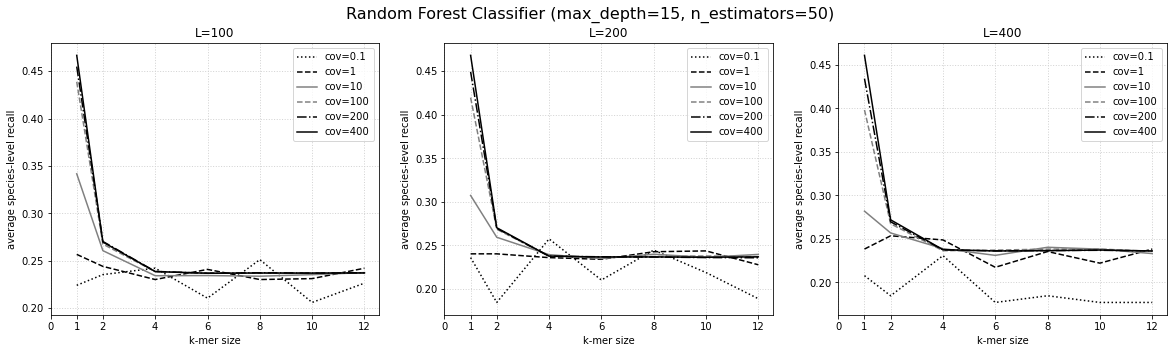

In [127]:
filename='data/runs-10000/rf-multi.combined.csv'
plot_graphs(filename)